# **CLUSTERING (AGRUPACIÓN) DE SEMILLAS**
- Alfredo Marías Felices Vera 100495820@alumnos.uc3m.es
- Liang Ji Zhu 100495723@alumnos.uc3m.es
- Grupo 20

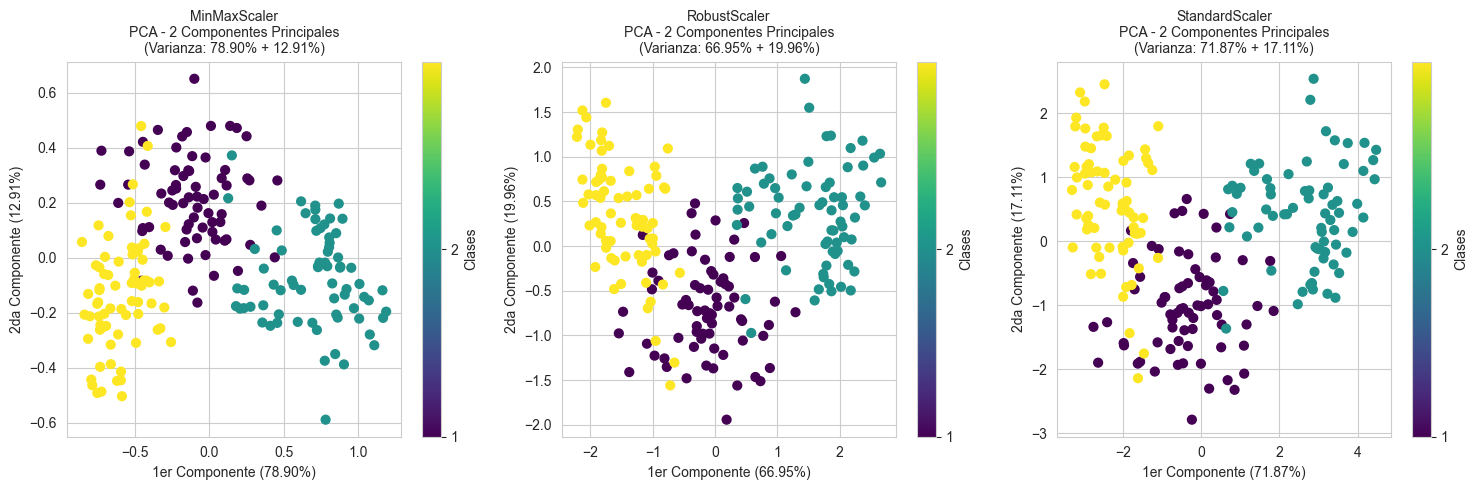

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, RobustScaler, StandardScaler
import numpy as np

# Establecer semilla aleatoria
SEED = 100495820
np.random.seed(SEED)

# Cargar datos
data = pd.read_csv('data/semillas.csv')
X = data.iloc[:, :-1]  # Asumimos que las características están en todas las columnas excepto la última
y = data.iloc[:, -1]   # Asumimos que la última columna contiene las etiquetas

# Lista de scalers
scalers = {
    'MinMaxScaler': MinMaxScaler(),
    'RobustScaler': RobustScaler(),
    'StandardScaler': StandardScaler()
}

# Visualización
plt.figure(figsize=(15, 5))
for i, (scaler_name, scaler) in enumerate(scalers.items(), 1):
    # Pipeline con scaler y PCA
    pipeline = Pipeline([
        ('scaler', scaler),
        ('pca', PCA(n_components=2, random_state=SEED))
    ])

    # Transformar datos
    X_reduced = pipeline.fit_transform(X)
    pca = pipeline.named_steps['pca']
    explained_variance = pca.explained_variance_ratio_

    # Gráfico
    plt.subplot(1, 3, i)
    plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=y, cmap='viridis', s=40)
    plt.title(f'{scaler_name}\nPCA - 2 Componentes Principales\n(Varianza: {explained_variance[0]:.2%} + {explained_variance[1]:.2%})', fontsize=10)
    plt.xlabel('1er Componente ({:.2%})'.format(explained_variance[0]))
    plt.ylabel('2da Componente ({:.2%})'.format(explained_variance[1]))
    plt.colorbar(ticks=range(3), label='Clases')


plt.tight_layout()
plt.show()